<a href="https://colab.research.google.com/github/chicofreitas/sprint-ii-puc-rio-datasets/blob/main/Sprint_II_A_Occupancy_Detection_PUC_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint II A - MACHINE LEARNING & ANALYTICS

## Data Science & Analytics - PUC Rio

### Francisco das Chagas Alves Freitas

Jun, 15. 2023
Teresina, PI

# 1 Descrição do Problema

Para a realização deste notebook foi utilizado o dataset **Occupancy Detection**, disponível no UCI Machine Learning Repository no link: https://archive.ics.uci.edu/dataset/357/occupancy+detection. Este dataset consiste em dados experimentais usados para classificação binária (ocupação de uma sala) a partir das variáveis *Temperatura*, *Umidade*, *Intensidade da Luz* e nível de *CO2*. A ocupação do solo foi obtida a partir de fotos com carimbo de tempo que foram tiradas a cada minuto.

Como os dados se encontram separados em três arquivos de texto (.txt) e seus dados foram coletados em datas e horários distintos, optei por mesclar os arquivos e utilizar **validação cruzada** para conseguir um número maior de grupos de dados.

O dataset Occupancy Detection foi escolhido por se enquadrar em um problema de classificação, em particular por possuir apenas duas classes.





Os datasets originais possuem os seguintes atributos:

* **date:** Momento no tempo em que os dados foram registrados. time year-month-day hour:minute:second.
* **Temperature:** medida em graus *Celsius*;
* **Relative Humidity:** registro da **porcentagem** (%) da humidade do ar;
* **Light:** quantidade de luz no ambiente, medida em **Lux**;
* **CO2:** concentração de CO2 medida em Partes Por Milhão (ppm);
* **Humidity Ratio:** Quantidade derivada da razão entre a temperatura e a
 humidade relativa do ar. Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air;
* **Occupancy:** Valor binário 0 ou 1, onde 0 representa a situação (status) de não ocupado, e 1 a situação de ocupado.

# 2 Preparação dos Dados


In [96]:
# Configuração para não exibir os warnings
#import warnings
#warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler # normalização
from sklearn.preprocessing import StandardScaler # padronização

from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada

from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo

from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM

from sklearn.metrics import confusion_matrix, classification_report
import itertools

from imblearn.over_sampling import SMOTE

In [2]:
# Carga do dataset

labels_attributes = [
    "id",
    "date",
    "temp",
    "hum",
    "light",
    "co2",
    "humRatio",
    "occupancy"
  ]

data_url = 'https://raw.githubusercontent.com/chicofreitas/sprint-ii-puc-rio-datasets/main/datasets/occupancy-detection/dataset.csv'

# Lendo CSV definindo a coluna "date" como índice
df = pd.read_csv(data_url, names=labels_attributes, on_bad_lines='skip', parse_dates=True, index_col='date')

# Removendo a coluna id
df.drop(['id'], axis='columns', inplace=True)

df.head()

,temp,hum,light,co2,humRatio,occupancy
date,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


Em um primeiro momento, é possível visualizar o grande intervalo de valores nos atributos **light**, **co2** (ambos da ordem de 10e+2) e **humRatio** (da ordem de 10e-3).

In [ ]:
df.tail()

,temp,hum,light,co2,humRatio,occupancy
date,,,,,,
2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1
2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1
2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,1
2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1
2015-02-18 09:19:00,21.000,28.1000,409.00,1864.00,0.004321,1


In [ ]:
df.shape

(20560, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20560 entries, 2015-02-02 14:19:00 to 2015-02-18 09:19:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       20560 non-null  float64
 1   hum        20560 non-null  float64
 2   light      20560 non-null  float64
 3   co2        20560 non-null  float64
 4   humRatio   20560 non-null  float64
 5   occupancy  20560 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.1 MB


In [ ]:
df.describe()

,id,temp,hum,light,co2,humRatio,occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,4116.576070,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,2684.372188,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,1.000000,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,1760.000000,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,3808.000000,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,6378.000000,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,9752.000000,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [3]:
df.groupby('occupancy').size()

occupancy
0    15810
1     4750
dtype: int64

## 2.1 Visualizações

### 2.1.1 Visualizações Unidimensionais

#### Séries Temporais

Por se tratar de séries temorais, abaixo são realizadas algumas visualizações a fim de tentar compreender melhor as interações e relações entre as variáveis ao longo do tempo. Desta forma, espera-se identificar tendências compartilhadas ou padrões que se repetem entre as variáveis.

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

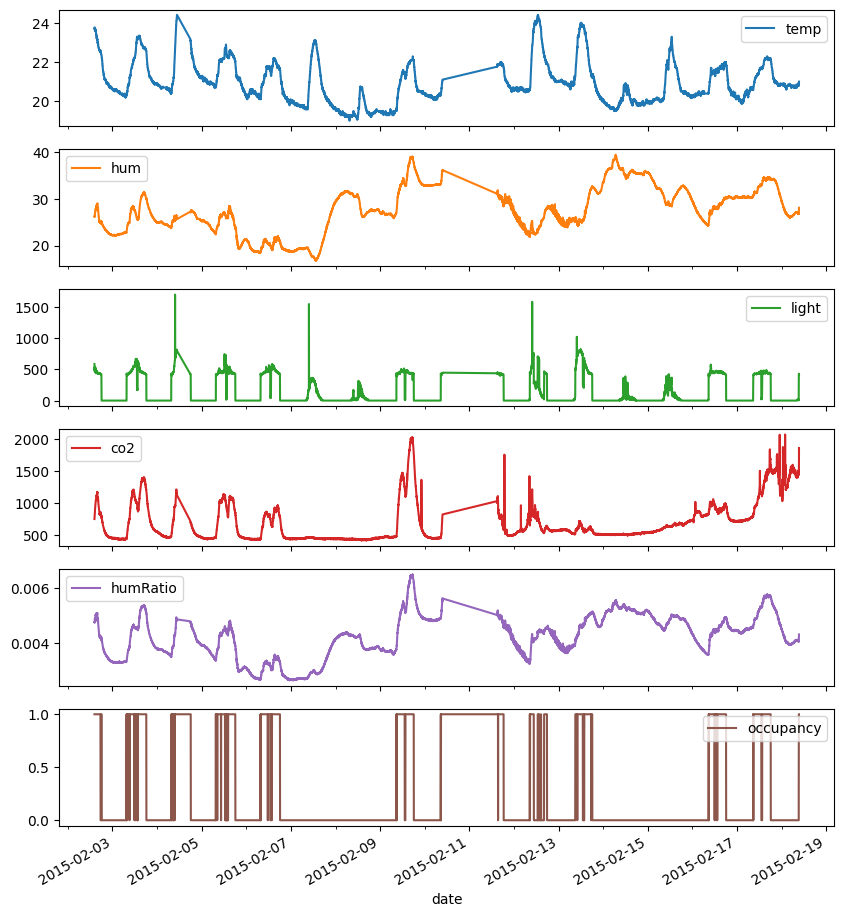

In [6]:
df.plot(subplots=True, figsize=(10, 12))

Como existem dois longos pedíodos de inatividade (occupancy=0), nos intervalos 07-08/02/2015 e 14-15/02/2015, abaixo são exibidas as visualizações dos atributos em um intervalo de tempo menor, entre estas datas.

Uma análise posterior mostrou que estes dois intervalos coincidem com dois finais de semana no mês de Fevereiro de 2015. Mesmo nestes dois períodos, os sensores continuaram em funcionamento, coletando os dados minuto a minuto. Isso pode ser constatado pelas variações nos valores de *temperatura*, *humidade*, *luminosidade* e concentração de *CO2*.

In [7]:
df_day_range_07_09 = df['2015-02-07':'2015-02-09']

df_day_range_07_09.head()

,temp,hum,light,co2,humRatio,occupancy
date,,,,,,
2015-02-07 00:00:00,20.0000,18.700,0.0,438.000000,0.002696,0
2015-02-07 00:01:00,19.9725,18.745,0.0,433.666667,0.002698,0
2015-02-07 00:02:00,20.0000,18.790,0.0,434.500000,0.002709,0
2015-02-07 00:03:00,20.0000,18.700,0.0,434.000000,0.002696,0
2015-02-07 00:04:00,20.0000,18.745,0.0,438.500000,0.002703,0


In [8]:
df_day_range_07_09.tail()

,temp,hum,light,co2,humRatio,occupancy
date,,,,,,
2015-02-09 23:55:00,20.39,32.9,0.0,502.5,0.004877,0
2015-02-09 23:55:59,20.39,32.9,0.0,501.0,0.004877,0
2015-02-09 23:57:00,20.39,32.9,0.0,502.0,0.004877,0
2015-02-09 23:57:59,20.39,32.9,0.0,505.0,0.004877,0
2015-02-09 23:58:59,20.39,33.0,0.0,506.5,0.004891,0


In [9]:
df_day_range_02_07 = df['2015-02-02':'2015-02-07']

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

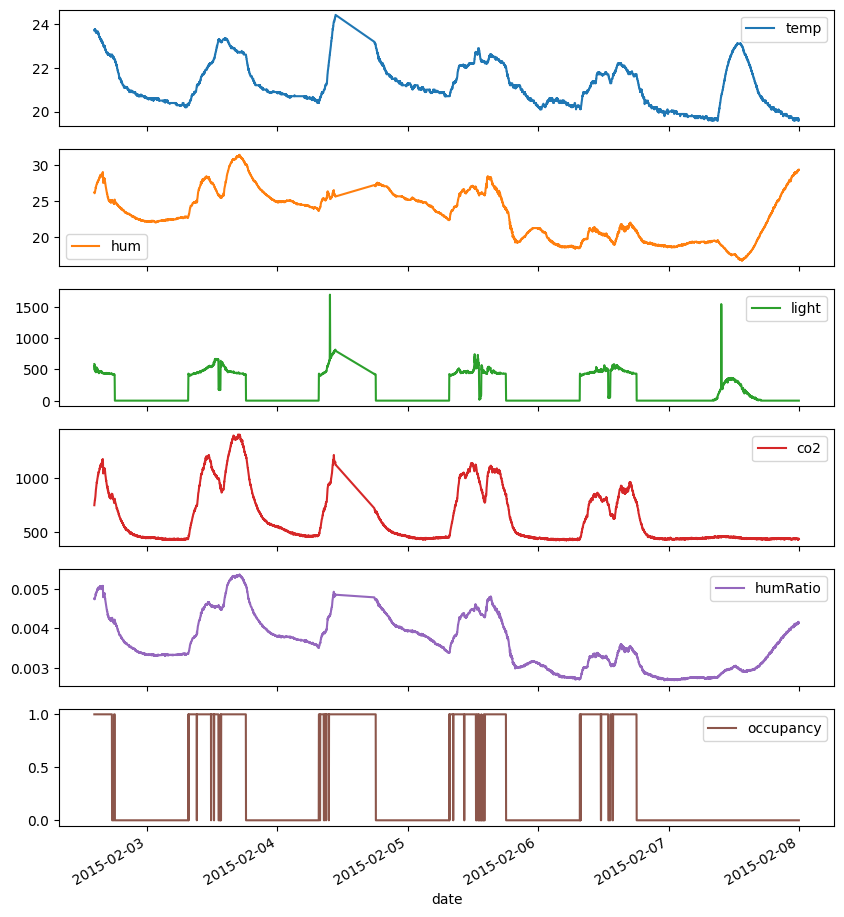

In [10]:
df_day_range_02_07.plot(subplots=True, figsize=(10, 12))

A partir dessas visualizações, é possível observar que á uma relação aparente entre os atributos e o target *occupancy*.

#### Blox Plots

Para comparar as quantidades e frequências de cada variável, assim como uam possível tendências em alguma delas, abaixo são exibidos os gráficos de barra de cada variável.

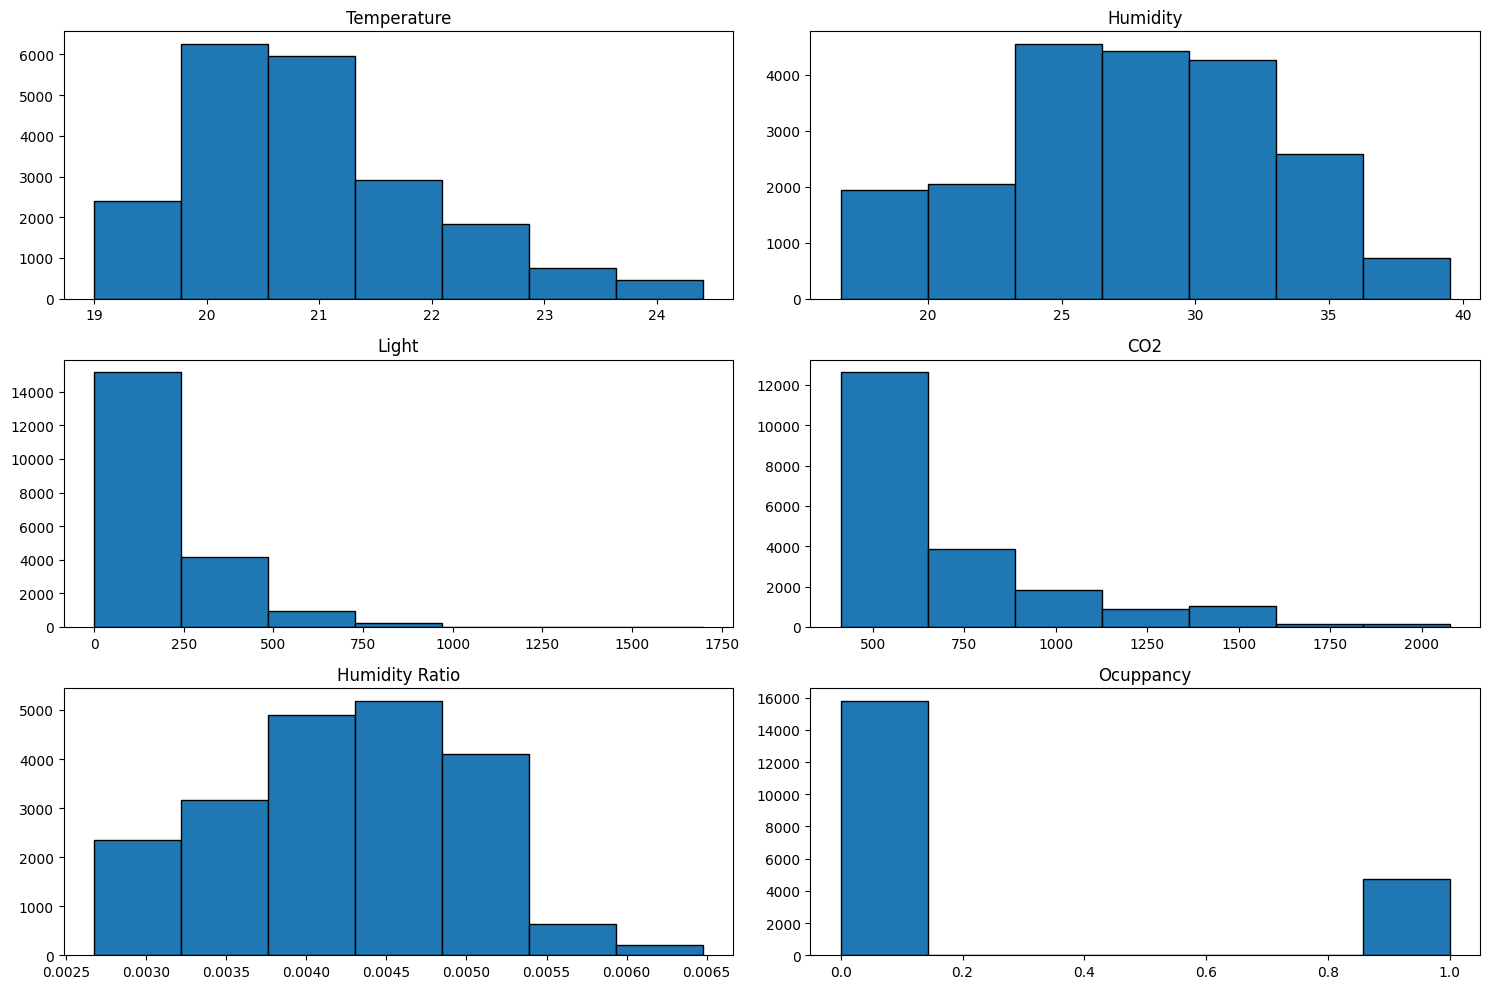

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

ax[0, 0].hist(df['temp'], bins=7,edgecolor='black')
ax[0, 0].set_title('Temperature')

ax[0, 1].hist(df['hum'], bins=7,edgecolor='black')
ax[0, 1].set_title('Humidity')

ax[1, 0].hist(df['light'], bins=7,edgecolor='black')
ax[1, 0].set_title('Light')

ax[1, 1].hist(df['co2'], bins=7,edgecolor='black')
ax[1, 1].set_title('CO2')

ax[2, 0].hist(df['humRatio'], bins=7,edgecolor='black')
ax[2, 0].set_title('Humidity Ratio')

ax[2, 1].hist(df['occupancy'], bins=7,edgecolor='black')
ax[2, 1].set_title('Ocuppancy')

fig.tight_layout()

#### Density Plots

Abaixo, seguem os density plots de cada variável com a finalidade de compreender como os dados estão distribuídos e busca de possíveis outliers.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

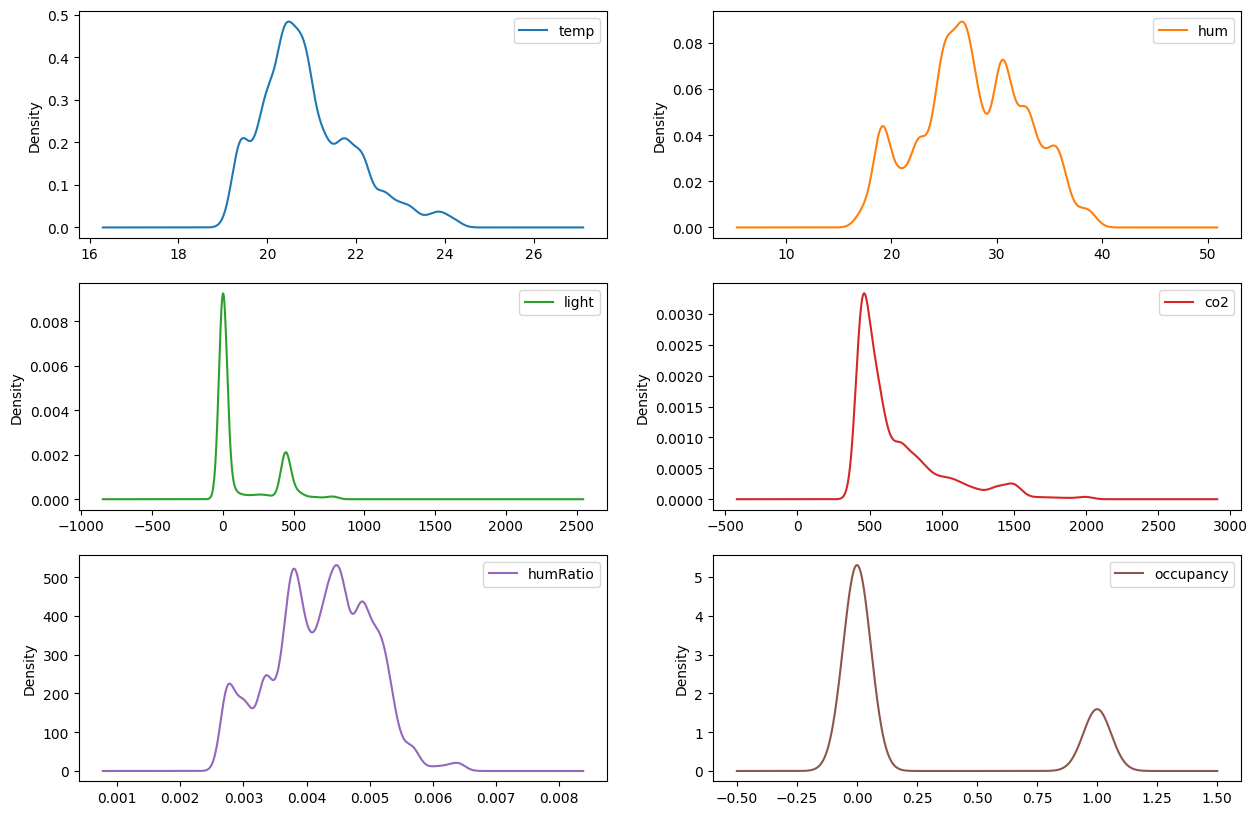

In [12]:
df_for_density_plot = df.loc[ : , ['temp', 'hum', 'light', 'co2', 'humRatio', 'occupancy']]
df_for_density_plot.plot(kind = 'density', subplots = True, layout = (3,2), sharex = False, figsize = (15, 10))

#### Box Plots

Como complemento da análise acima, realizada com os density plots, abaixo os box plots são exibidos para visualiar a mediana, a variação e dispersão das variáveis.

temp            Axes(0.125,0.747241;0.227941x0.132759)
hum          Axes(0.398529,0.747241;0.227941x0.132759)
light        Axes(0.672059,0.747241;0.227941x0.132759)
co2             Axes(0.125,0.587931;0.227941x0.132759)
humRatio     Axes(0.398529,0.587931;0.227941x0.132759)
occupancy    Axes(0.672059,0.587931;0.227941x0.132759)
dtype: object

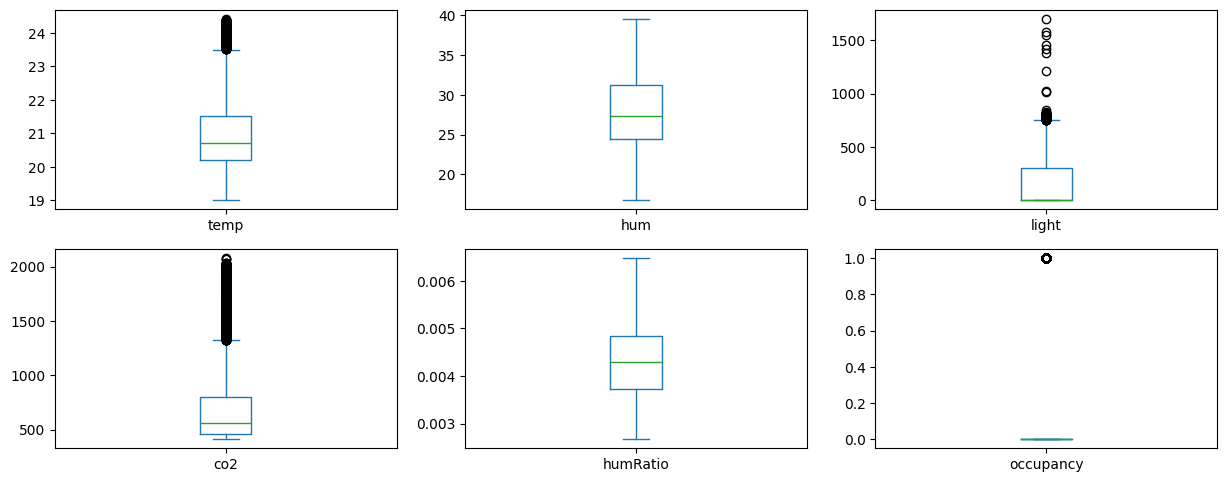

In [13]:
df_copy = df_for_density_plot

df_copy.plot(kind = 'box', subplots = True, layout = (5,3), sharex = False, sharey = False, figsize = (15,15))

### 2.1.2 Visualizações Multimodais

#### Heatmap

<Axes: >

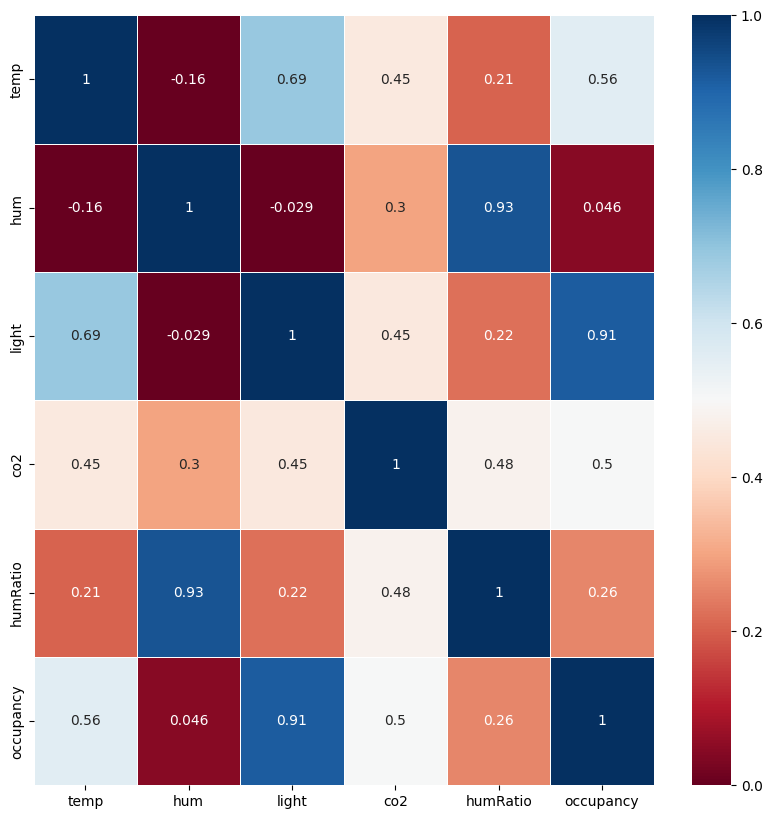

In [14]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

sns.heatmap(vmin=0.0, vmax=1.0, data=df_copy.corr(), annot=True, cmap='RdBu', linewidths=.5, ax=ax)

Como conclusões sobre o mapa de calor acima, é possível observar a forte relação entre a luminosidade e a ocupação do espaço.

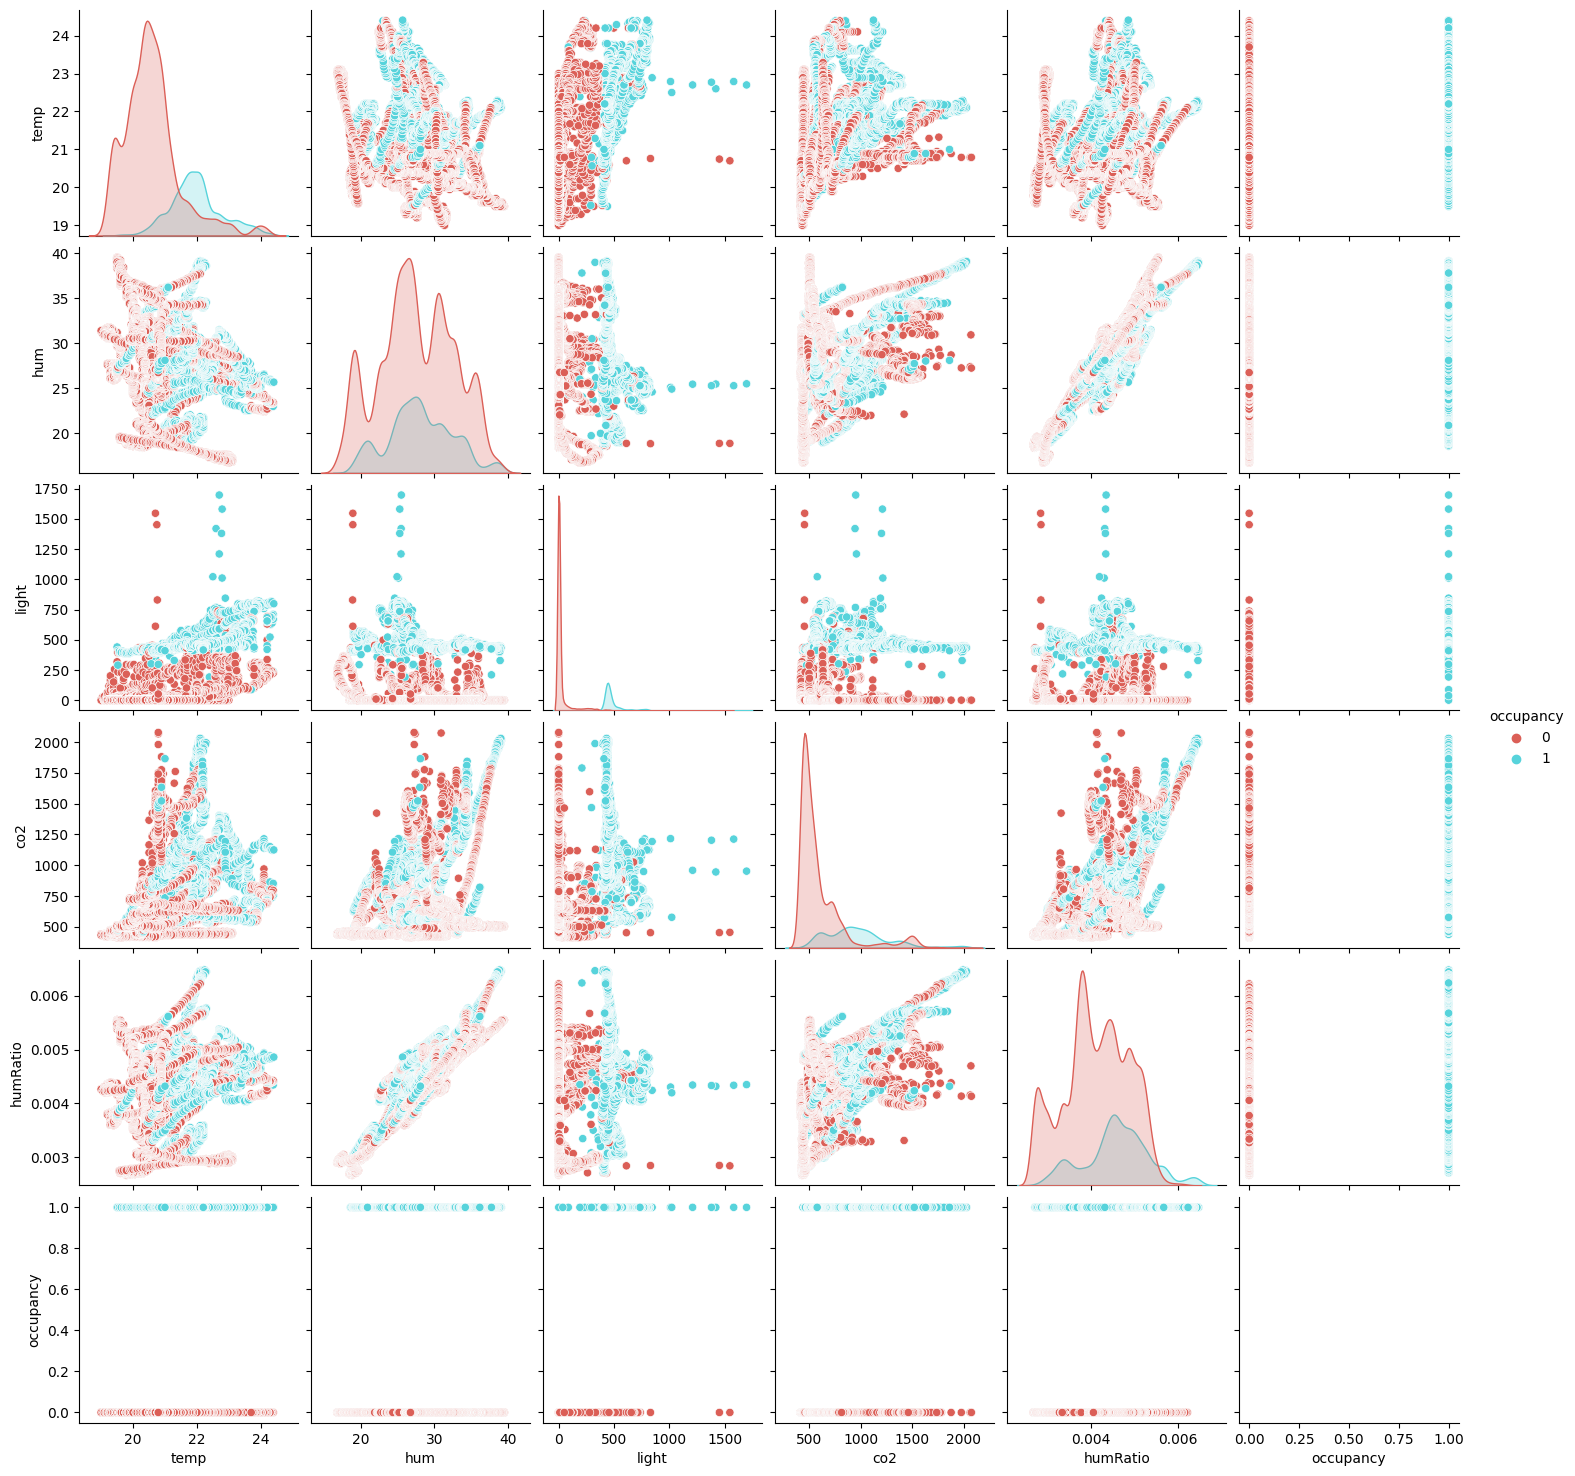

In [ ]:
df_reseted_indexes = df_copy.reset_index()
sns.pairplot(df_reseted_indexes, hue = 'occupancy', palette='hls',
             x_vars=['temp', 'hum','light', 'co2', 'humRatio', 'occupancy'],
             y_vars=['temp', 'hum','light', 'co2', 'humRatio', 'occupancy'])

Interpretação do Pair Plot acima... Lorem ipsum...

In [192]:
# Separate the majority and minority classes
majority_class = df[df['occupancy'] == 0]
minority_class = df[df['occupancy'] == 1]

# Calculate the number of instances in the majority class
majority_count = majority_class.shape[0]

# Calculate the number of instances to remove (one-third of majority class)
instances_to_remove = int(majority_count // 3)

# Remove one-third of the majority class instances randomly
majority_class = majority_class.sample(n=majority_count - instances_to_remove*2, random_state=42)

# Concatenate the majority and minority classes back together
balanced_data = pd.concat([majority_class, minority_class])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42)

balanced_data.groupby('occupancy').size()

occupancy
0    5270
1    4750
dtype: int64

### 2.1.3 Feature Selection

Por que dropei a humidade? Vamos observar o heatmap.

In [193]:
# seleção de atributos para normalização.
selected_attibutes = balanced_data.drop(columns=['hum', 'humRatio', 'temp'])

selected_attibutes.head()

,light,co2,occupancy
date,,,
2015-02-16 17:10:00,427.250000,971.000000,1
2015-02-13 15:29:00,480.666667,577.666667,1
2015-02-09 13:44:00,454.000000,1110.750000,1
2015-02-17 20:38:00,0.000000,1530.500000,0
2015-02-09 21:49:00,0.000000,759.000000,0


### 2.1.4 Transformação dos Dados


#### Normalização dos Dados

Como pôde ser observado no df.head() executado na seção 2 (Preparação dos Daddos) os dados possuem intervalos muito grandes. Desta forma, faz-se necessário realizar a normalização de todas as variáveis.

In [194]:
# Separando os valores do dataset em componentes de input (X) e output (Y)
X = selected_attibutes.values[:,0:2]
y = selected_attibutes.values[:,2]


In [195]:
# Normalização

# definindo o transformador como min max scaler
scaler = MinMaxScaler()

# transformando os dados
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[0.25 0.35]
 [0.28 0.1 ]
 [0.27 0.43]
 ...
 [0.25 0.39]
 [0.   0.07]
 [0.28 0.29]]


In [158]:
# Padronização

# definindo o transformador como standard scaler
scaler = StandardScaler()

# transformando os dados
X_scaled = scaler.fit_transform(X_scaled)



#### Nota sobre One Hot Encoding

A técnica de **One Hot Ecoding** não será utilizada aqui, pois o target constitui de apenas dois valores (binário), 0 e 1.

### 2.1.5 Separação dos Dados

Nesta seção, vamos separar o dataset em grupos de treino e testes.

#### Holdout

In [223]:
# Separação em bases de treino e teste (holdout)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
    test_size=0.20, shuffle=True, random_state=42, stratify=y)

#### Validação Cruzada

In [224]:
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

## 3 Modelagem e Treinamento

KNN: 0.991767 (0.001692)
CART: 0.985778 (0.002573)
NB: 0.980788 (0.003405)
SVM: 0.991766 (0.001867)


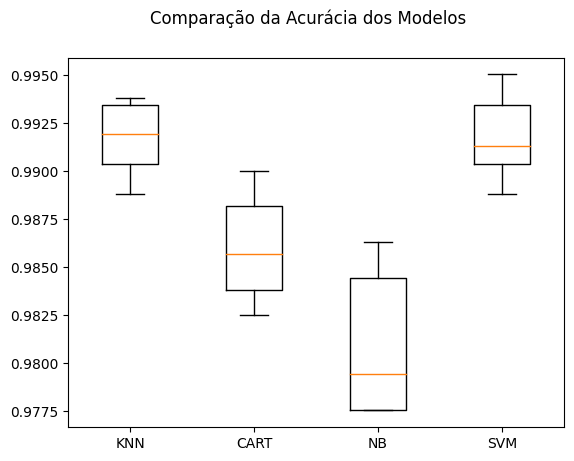

In [225]:
# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 4 Avaliação de Resultados


In [231]:
# Criando um modelo com todo o conjunto de treino
model = KNeighborsClassifier()
#model = DecisionTreeClassifier()
#model = SVC()
#model = GaussianNB()

model.fit(X_train, y_train)

SVC()

#### Realizando Predições.

Neste ponto, vamos realizar previsões (obter os targets) utilizando o modelo treinado.

In [232]:
# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

#### Estimando a Acurácia do Modelo

In [233]:
# Estimando a acurácia no conjunto de teste
print(accuracy_score(y_test, predictions))

0.9910179640718563


#### Visualização Valores Reais X Preditos

In [234]:
labels = ['Desocupado', 'Ocupado']

y_pred = list()
y_true = list()

# Visualizar algumas imagens com suas previsões
test_len = len(X_test)

for i in np.arange(0, test_len):
    # Obter a classe real e a previsão do modelo para a imagem
    real_class = labels[int(y_test[i])]
    predicted_class = labels[int(predictions[i])]

    y_true.append(real_class)

    y_pred.append(predicted_class)

    #probability = predictions[i][np.argmax(predictions[i])]

    print(f'Real: {real_class}, Previsto: {predicted_class}')


Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Desocupado, Previsto: Desocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Desocupado, Previsto: Desocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Desocupado, Previsto: Desocupado
Real: Ocupado, Previsto: Ocupado
Real: Ocupado, Previsto: Ocupado
Real

#### Matriz de Confusão

Matriz de confusão sem normalização


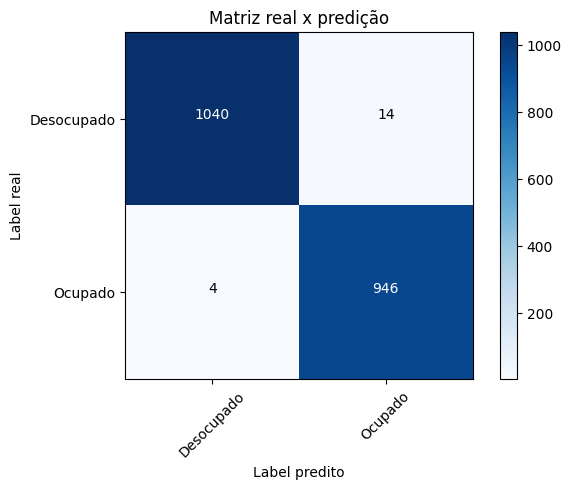

In [235]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

#
cnf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=labels,
                      normalize= False,
                      title='Matriz real x predição')